# Task 3

In [ ]:
!pip install bayesian-optimization

In [ ]:
# Import required packages
import csv
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns
from datetime import datetime, timedelta
from tabulate import tabulate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional #Embedding, Attention
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from bayes_opt import BayesianOptimization

In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

path="/content/drive/MyDrive/project/(1999250)_EHR"

Mounted at /content/drive


In [ ]:
path = path + '/data'

In [ ]:
balanced_dataset = pd.read_csv(path + '/balanced_dataset.csv', index_col='Unnamed: 0')

# 3.1 Ignoring the order of the micro events in the prediction

We are requested to implement a way to ignore the order in which the micro events happened, while obviously conserving the order in which the macro events happened. In other words, we need to manipulate the data that is passed to the model such that it captures the temporal component of the macroevents (the order in which they happened) but ignores the temporal component of the microevents (therefore, not considering the order in which these happened). Hence, it appears that we have at least two options:

1) Completely ignore the microevents and drop them, so we just consider the macroevents.

2) Or we can aggregate/summarize those microevents, in order not to completely lose the information given by them, and attach these summaries to the macroevents. In this way, the aggregation of the microevents will "accompany" the macroevents.

Lastly, note that the data, which we have used through the project, doesn't contain numerical values. For this reason, the don't have a pletora of options from which to choose our strategy to accomplish this task, as we can't aggregate using minimum, maximum, mean, standard deviation. Therefore, out stategy is:

**The strategy**

We are gonna group by patient, macroevent and date of the macroevent. In that order. And we are going to count frequency of micro events that match with the date of the macroevent.

By following this approach, we hope to capture the overall characteristics and temporal component of the macro events, while discarding the specific sequence in which the microevents happened between or within each macroevent.

In [ ]:
def remove_temporality_microevents(balaced_dataset_i):
  # We define the events that are gonna be considered as macroevents
  macro_events = ['AMD047','AMD048','AMD049','AMD071','AMD081','AMD082','AMD208','AMD303']

  # Separating macro and microevents.
  macro_events_data = balanced_dataset[balanced_dataset['code'].isin(macro_events)]
  micro_events_data = balanced_dataset[~balanced_dataset['code'].isin(macro_events)]
  macro_events_data = pd.DataFrame(macro_events_data)
  micro_events_data = pd.DataFrame(micro_events_data)

  # Creating a copy of the macroevents with just the columns of interest
  macro_events_data_2 = macro_events_data.iloc[:, :3].copy()

  # Grouping microevents and counting how many microevents happened on each date for each patient
  micro_events = micro_events_data.groupby(['id_center','id_ana','date']).size().reset_index(name='row_count')

  # Take all the patients in macro events and copy them in the micro events.
  # For 1 micro event, we can have multiple macro events that happened in different dates
  # We're interested in having each micro event associated with ALL the dates in the macro events that exist for that id_center and id_ana
  merged_df = pd.merge(micro_events, macro_events_data_2[['id_center', 'id_ana', 'date']], on=['id_center', 'id_ana'], how='left')

  del macro_events_data_2
  del micro_events

  # Drop those microevents that don't have a match in the macroevents
  merged_df = merged_df.dropna(subset=['date_y'])

  #merged_df = merged_df[:2000000]

  # Group all dates of macroevents, associated with a patient, in a list.
  # see that there can be multiple rows for the same patient BUT with different date (corresponding to a date of a microevent)
  # however, the list of the dates of the macroevents, is the same for all the rows of the same patient.
  grouped_df = merged_df.groupby(['id_center', 'id_ana', 'date_x'])['date_y'].agg(list).reset_index()

  del merged_df
  # Changing datatypes to dates
  grouped_df['date_x'] = pd.to_datetime(grouped_df['date_x'])
  grouped_df['date_y'] = grouped_df['date_y'].apply(lambda dates: np.array([pd.to_datetime(date) for date in dates]))

  # KEY STEP
  # finding, for the date each microevent, what's the closest date among all the macroevents associated to that patient
  # put that closest date in the new column
  grouped_df['closest_macro_date'] = grouped_df.apply(lambda row: min(row['date_y'], key=lambda x: abs(x - row['date_x'])), axis=1)

  # dropping column that isn't gonna be used anymore
  grouped_df = grouped_df.drop('date_y', axis = 1)

  # Now grouping by id_center, id_ana and the corresponding date in "closest_macro_date" that we are going to merge to in macro events
  grouped_data = grouped_df.groupby(['id_center', 'id_ana', 'closest_macro_date']).size().reset_index(name='number_of_microevents')

  # Renaming the column closes_macro_date to date, in order to easily merge
  grouped_data = grouped_data.rename(columns={'closest_macro_date': 'date'})

  # Being sure that date is treated as a date
  macro_events_data['date'] = pd.to_datetime(macro_events_data['date'])

  # Adding the number of microevents for each patient in the macroevents
  # associating them to the closest date between the microevent and all the dates of macroevents for that patient
  macro_events_data = macro_events_data.merge(grouped_data, on = ['id_center','id_ana','date'], how = "left")

  return macro_events_data

In [ ]:
#macro_events_data = remove_temporality_microevents(balanced_dataset)

In [ ]:
#macro_events_data.to_csv(path+'task_3_1_temporality_microevents_removed.csv', mode='w', header=True, index=False)
macro_events_data = pd.read_csv(path+'task_3_1_temporality_microevents_removed.csv')

In [ ]:
macro_events_data

,id_center,id_ana,date,code,label,age_at_event,number_of_microevents
0,1,5,2000-12-02,AMD049,1,58,1.0
1,1,5,2001-03-22,AMD049,1,59,2.0
2,1,5,2002-02-11,AMD049,1,60,1.0
3,1,5,2002-02-14,AMD049,1,60,1.0
4,1,5,2003-01-17,AMD049,1,61,2.0
...,...,...,...,...,...,...,...
365187,501,579,2014-09-09,AMD047,1,56,5.0
365188,501,579,2014-09-09,AMD047,1,78,5.0
365189,501,2683,2017-11-13,AMD049,1,74,2.0
365190,501,2683,2017-11-13,AMD049,1,73,2.0


In [ ]:
# We put a zero in the number of microevents for those patients that didn't have microevents but only macroevents
macro_events_data.loc[(macro_events_data.number_of_microevents.isna()),'number_of_microevents'] = 0

In [ ]:
macro_events_data.shape

(365192, 7)

Split in train and test

In [ ]:
# Encoding the code variable, which should be treated as categorical
label_encoder = LabelEncoder()
macro_events_data['code'] = label_encoder.fit_transform(macro_events_data['code'])


np.random.seed(324)
test_idx = np.random.choice(macro_events_data.shape[0], size = int(0.2*macro_events_data.shape[0]), replace = False)

test_macro_events_data = macro_events_data.iloc[test_idx]
train_macro_events_data = macro_events_data.drop(test_idx, axis = 0)

# 3.2 Concentration item: Bayesian Optimization

In [ ]:
def preprocess_t_lstm(macro_events_data):
  # guarantee variable is treated as date
  # Preprocess the trajectories_x
  macro_events_data = pd.DataFrame(macro_events_data)
  macro_events_data['date'] = pd.to_datetime(macro_events_data['date'])

  # computing for each patient the number of days that have passed for each event from its minimum date
  macro_events_data['days_since_min_date'] = macro_events_data.groupby(['id_center', 'id_ana'])['date'].transform(lambda x: (x - x.min()).dt.days)

  # splitting data into features and variable to predict
  X = macro_events_data.drop(['label', 'date'], axis=1).values.astype(float)
  y = macro_events_data['label'].values

  X = np.reshape(X, (X.shape[0], 1, X.shape[1]))
  return X,y

def t_lstm(trajectories_data, epochs_i = 5, batch_size_i = 128, units = 64, learning_rate = 0.001, verbose = 'auto'):
  # need to give T-LSTM the days that have passed for each event since the mionimum date of each patient
  # this as it expects only numerical.

  # guarantee variable is treated as date
  # Preprocess the trajectories_x
  trajectories_data['date'] = pd.to_datetime(trajectories_data['date'])

  # computing for each patient the number of days that have passed for each event from its minimum date
  trajectories_data['days_since_min_date'] = trajectories_data.groupby(['id_center', 'id_ana'])['date'].transform(lambda x: (x - x.min()).dt.days)

  # splitting data into features and variable to predict
  X = trajectories_data.drop(['label', 'date'], axis=1).values.astype(float)
  y = trajectories_data['label'].values

  # splitting into train and test data (20% for testing)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

  # need to reshape. set to 1 as each sample must be treated as single time step-
  # this is the key to capture the temporal dependencies between events. Requirement of T-LSTM
  X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
  X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

  # replicating the architecture of the simplest LSTM we implemented
  model = Sequential()
  model.add(LSTM(units=units, input_shape=(1, X_train.shape[2])))
  model.add(Dense(units=1, activation='sigmoid')) # as it is a dummy

  model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

  # Training
  model.fit(X_train, y_train, epochs=epochs_i, batch_size=batch_size_i, verbose = verbose)

  # Evaluating...
  loss, accuracy = model.evaluate(X_test, y_test)
  return model,loss,accuracy

In [ ]:
def hyperparameter_tuning(units, learning_rate):
  units = int(np.ceil(units))
  return t_lstm(trajectories_data = train_macro_events_data, epochs_i = 5, units = units, learning_rate = learning_rate, verbose = 0)[2]


optimizer = BayesianOptimization(f=hyperparameter_tuning, pbounds={"units": (16, 128), "learning_rate": (0.001, 0.01)})

optimizer.maximize(init_points=5, n_iter=5)

|   iter    |  target   | learni... |   units   |
-------------------------------------------------
1826/1826 [==============================] - 6s 3ms/step - loss: 0.3828 - accuracy: 0.7905
| 1         | 0.7905    | 0.008057  | 37.9      |
1826/1826 [==============================] - 7s 3ms/step - loss: 0.4279 - accuracy: 0.7675
| 2         | 0.7675    | 0.009067  | 77.92     |
1826/1826 [==============================] - 7s 3ms/step - loss: 0.3746 - accuracy: 0.7913
| 3         | 0.7913    | 0.007262  | 59.56     |
1826/1826 [==============================] - 6s 3ms/step - loss: 0.4211 - accuracy: 0.7227
| 4         | 0.7227    | 0.007768  | 116.0     |
1826/1826 [==============================] - 7s 4ms/step - loss: 0.3880 - accuracy: 0.7762
| 5         | 0.7762    | 0.006341  | 104.3     |
1826/1826 [==============================] - 6s 3ms/step - loss: 0.3748 - accuracy: 0.7913
| 6         | 0.7913    | 0.002944  | 104.3     |
1826/1826 [==============================] - 7s 4ms/st

In [ ]:
bayes_model, bayes_loss, bayes_acc = t_lstm(trajectories_data = train_macro_events_data, epochs_i = 10, units = 64, learning_rate = 0.008)

Epoch 1/10
1826/1826 [==============================] - 10s 5ms/step - loss: 0.5316 - accuracy: 0.7009
Epoch 2/10
1826/1826 [==============================] - 9s 5ms/step - loss: 0.4784 - accuracy: 0.7336
Epoch 3/10
1826/1826 [==============================] - 8s 5ms/step - loss: 0.4407 - accuracy: 0.7527
Epoch 4/10
1826/1826 [==============================] - 8s 4ms/step - loss: 0.4107 - accuracy: 0.7654
Epoch 5/10
1826/1826 [==============================] - 9s 5ms/step - loss: 0.4171 - accuracy: 0.7602
Epoch 6/10
1826/1826 [==============================] - 8s 4ms/step - loss: 0.3981 - accuracy: 0.7767
Epoch 7/10
1826/1826 [==============================] - 9s 5ms/step - loss: 0.4011 - accuracy: 0.7797
Epoch 8/10
1826/1826 [==============================] - 8s 5ms/step - loss: 0.3965 - accuracy: 0.7766
Epoch 9/10
1826/1826 [==============================] - 8s 4ms/step - loss: 0.4056 - accuracy: 0.7686
Epoch 10/10
1826/1826 [==============================] - 6s 3ms/step - loss: 0.37

## Comparison!

In [ ]:
def easy_LSTM(trajectories_data, epochs_i = 5, batch_size_i = 128):
  # Splitting the trajectories_data in features and label to predict
  X = trajectories_data[['id_center', 'id_ana', 'code', 'number_of_microevents']]
  y = trajectories_data['label']

  # Splitting trajectories_data into training and testing trajectories_datasets. 20% of trajectories_data to test.
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

  # Defining the very simple LSTM model
  model = Sequential()
  model.add(LSTM(units=64, input_shape=(X_train.shape[1], 1)))
  model.add(Dense(units=1, activation='sigmoid')) # as it is a dummy

  # Compiling the model
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

  # Training the model
  model.fit(X_train, y_train, epochs = epochs_i, batch_size= batch_size_i)

  # Evaluating the model
  loss, accuracy = model.evaluate(X_test, y_test)

  return model,loss,accuracy

def medium_LSTM(trajectories_data, epochs_i = 5, batch_size_i = 128):
  # Splitting the trajectories_data in features and label to predict
  X = trajectories_data[['id_center', 'id_ana', 'code', 'number_of_microevents']]
  y = trajectories_data['label']

  # Splitting trajectories_data into training and testing trajectories_datasets. 20% of trajectories_data to test.
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

  # Scaling the features (gradient convergence)
  scaler = StandardScaler()
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)

  # Reshaping to avoid errors after the scaling
  X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
  X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

  # Defining the medium-level complexity model
  model = Sequential()
  model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], 1)))
  model.add(Dropout(0.2))
  model.add(LSTM(units=64))
  model.add(Dropout(0.2))
  model.add(Dense(units=1, activation='sigmoid'))

  # Compiling the model
  optimizer = Adam(learning_rate=0.01) #adjusting learning rate for faster but bouncier convergence
  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

  # Defining the early stop phase with a patience of 3 epochs
  early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

  # Training the model
  model.fit(X_train, y_train, epochs=epochs_i, batch_size=batch_size_i, validation_data=(X_test, y_test), callbacks=[early_stopping])

  # Evaluating the model
  loss, accuracy = model.evaluate(X_test, y_test)

  return model, loss, accuracy

def preprocess_complex_lstm(macro_events_data, scaler, max_sequence_length):
  # Splitting the trajectories_data into features and label to predict
  X = macro_events_data[['id_center', 'id_ana', 'code']]
  y = macro_events_data['label']

  X = scaler.transform(X)

  # Padding the input sequences
  X_padded = np.zeros((max_sequence_length, X.shape[1]))
  X_padded[:X.shape[0], :] = X

  # Reshaping the input trajectories_data
  X_padded = X_padded[:, :, np.newaxis]

  return X,y

def complex_LSTM(trajectories_data, epochs_i=5, batch_size_i=128):
  # Splitting the trajectories_data into features and label to predict
  X = trajectories_data[['id_center', 'id_ana', 'code']]
  y = trajectories_data['label']

  # Splitting the trajectories_data into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

  # Feature scaling (better convergence!)
  scaler = StandardScaler()
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)

  # Padding the input sequences
  max_sequence_length = max(X_train.shape[0], X_test.shape[0])
  X_train_padded = np.zeros((max_sequence_length, X_train.shape[1]))
  X_test_padded = np.zeros((max_sequence_length, X_test.shape[1]))

  X_train_padded[:X_train.shape[0], :] = X_train
  X_test_padded[:X_test.shape[0], :] = X_test

  # Reshaping the input trajectories_data
  X_train_padded = X_train_padded[:, :, np.newaxis]
  X_test_padded = X_test_padded[:, :, np.newaxis]

  # Defining the LSTM model (using bidirectional, without attention)
  model = Sequential()
  model.add(Bidirectional(LSTM(units=128, return_sequences=True), input_shape=(X_train_padded.shape[1], 1)))
  model.add(Dropout(0.2))
  model.add(Bidirectional(LSTM(units=64, return_sequences=True)))
  model.add(Dropout(0.2))
  model.add(Dense(units=1, activation='sigmoid'))

  # Compiling
  optimizer = Adam(learning_rate=0.01)
  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

  # Defining the early stop phase with a patience of 3 epochs (not gonna be used)
  early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

  # Training
  model.fit(X_train_padded[:X_train.shape[0]], y_train, epochs=epochs_i, batch_size=batch_size_i, validation_split=0.2, callbacks=[early_stopping])

  # Evaluating...
  loss, accuracy = model.evaluate(X_test_padded[:X_test.shape[0]], y_test)

  return (model, scaler, max_sequence_length),loss, accuracy


def LSTM_f(trajectories_data, version_to_run = 'simple', n_epochs = 5):
  if version_to_run == 'simple':
    model,loss, accuracy = easy_LSTM(trajectories_data, epochs_i = n_epochs)
  elif version_to_run == 'medium':
    model,loss, accuracy = medium_LSTM(trajectories_data, epochs_i = n_epochs)
  else:
    model,loss, accuracy = complex_LSTM(trajectories_data, epochs_i = n_epochs)

  return model,loss,accuracy

In [ ]:
LSTM_data,LSTM_loss, LSTM_acc = LSTM_f(trajectories_data = train_macro_events_data, version_to_run = 'complex', n_epochs = 10)
LSTM_model, LSTM_scaler, max_sequence_length = LSTM_data

Epoch 1/10
1461/1461 [==============================] - 27s 14ms/step - loss: 0.3634 - accuracy: 0.7944 - val_loss: 0.3599 - val_accuracy: 0.7989
Epoch 2/10
1461/1461 [==============================] - 20s 13ms/step - loss: 0.3612 - accuracy: 0.7952 - val_loss: 0.3573 - val_accuracy: 0.7990
Epoch 3/10
1461/1461 [==============================] - 17s 12ms/step - loss: 0.3602 - accuracy: 0.7952 - val_loss: 0.3567 - val_accuracy: 0.7990
Epoch 4/10
1461/1461 [==============================] - 17s 12ms/step - loss: 0.3598 - accuracy: 0.7952 - val_loss: 0.3565 - val_accuracy: 0.7989
Epoch 5/10
1461/1461 [==============================] - 19s 13ms/step - loss: 0.3601 - accuracy: 0.7952 - val_loss: 0.3561 - val_accuracy: 0.7990
Epoch 6/10
1461/1461 [==============================] - 18s 12ms/step - loss: 0.3595 - accuracy: 0.7952 - val_loss: 0.3554 - val_accuracy: 0.7990
Epoch 7/10
1461/1461 [==============================] - 15s 10ms/step - loss: 0.3593 - accuracy: 0.7952 - val_loss: 0.3564 -

In [ ]:
t_LSTM_model,t_LSTM_loss, t_LSTM_acc = t_lstm(trajectories_data = train_macro_events_data, epochs_i = 10)

Epoch 1/10
1826/1826 [==============================] - 10s 4ms/step - loss: 0.4303 - accuracy: 0.7580
Epoch 2/10
1826/1826 [==============================] - 8s 4ms/step - loss: 0.3804 - accuracy: 0.7855
Epoch 3/10
1826/1826 [==============================] - 7s 4ms/step - loss: 0.3789 - accuracy: 0.7850
Epoch 4/10
1826/1826 [==============================] - 9s 5ms/step - loss: 0.3745 - accuracy: 0.7915
Epoch 5/10
1826/1826 [==============================] - 7s 4ms/step - loss: 0.3725 - accuracy: 0.7921
Epoch 6/10
1826/1826 [==============================] - 8s 5ms/step - loss: 0.3705 - accuracy: 0.7927
Epoch 7/10
1826/1826 [==============================] - 8s 4ms/step - loss: 0.3714 - accuracy: 0.7925
Epoch 8/10
1826/1826 [==============================] - 8s 4ms/step - loss: 0.3716 - accuracy: 0.7917
Epoch 9/10
1826/1826 [==============================] - 8s 5ms/step - loss: 0.3740 - accuracy: 0.7898
Epoch 10/10
1826/1826 [==============================] - 5s 3ms/step - loss: 0.36

In [ ]:
print('The standard LSTM test accuracy was', LSTM_loss, 'with loss', LSTM_acc)
print('The standard t-LSTM test accuracy was', t_LSTM_loss, 'with loss', t_LSTM_acc)
print('The bayes-optimized test accuracy was', bayes_loss, 'with loss', bayes_acc)

The standard LSTM test accuracy was 0.3577744662761688 with loss 0.793465793132782
The standard t-LSTM test accuracy was 0.3657255470752716 with loss 0.7923020124435425
The bayes-optimized test accuracy was 0.3783957064151764 with loss 0.7913607358932495


2283/2283 [==============================] - 5s 2ms/step


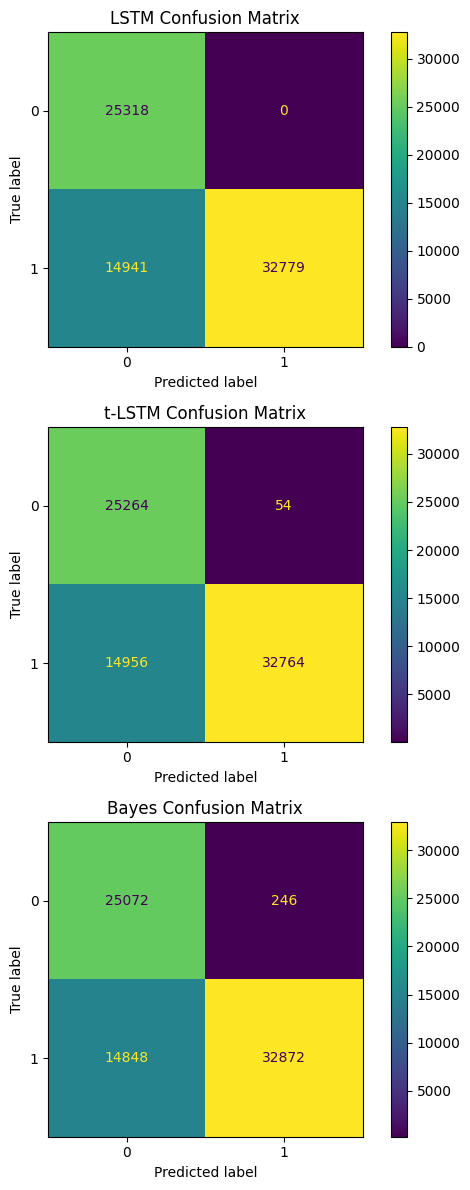

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages
fig,ax = plt.subplots(3,1, figsize = (6,12), tight_layout = True)

X_test, y_test = preprocess_complex_lstm(test_macro_events_data, LSTM_scaler, max_sequence_length)
actual = y_test

predicted = np.round(LSTM_model.predict(X_test)[:X_test.shape[0],-1,0])
cm_display = metrics.ConfusionMatrixDisplay.from_predictions(actual, predicted, ax = ax[0])
ax[0].set_title('LSTM Confusion Matrix')


X_test, y_test = preprocess_t_lstm(test_macro_events_data)
actual = y_test


predicted = np.round(t_LSTM_model.predict(X_test).flatten())
cm_display = metrics.ConfusionMatrixDisplay.from_predictions(actual, predicted, ax = ax[1])
ax[1].set_title('t-LSTM Confusion Matrix')

predicted = np.round(bayes_model.predict(X_test).flatten())
cm_display = metrics.ConfusionMatrixDisplay.from_predictions(actual, predicted, ax = ax[2])
ax[2].set_title('Bayes Confusion Matrix')

# Save each plot as SVG
for i, axi in enumerate(ax):
    axi.figure.savefig(f'plot_{i+1}.svg', format='svg')

plt.show()